In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import shutil
import math
import seaborn as sns
import nltk.translate.bleu_score as bleu
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('preprocessed_data.csv')
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [3]:
train, validation = train_test_split(data, test_size=0.2, random_state=42)

print(train.shape, validation.shape)

(272932, 3) (68234, 3)


In [4]:
train.head()

,italian,english_inp,english_out
76648,lei ha acceso le candele,<start> she lit the candles,she lit the candles <end>
246895,ecco una foto di tom che balla,<start> here is a picture of tom dancing,here is a picture of tom dancing <end>
109427,labbiamo fatto a scuola,<start> we did that at school,we did that at school <end>
324544,lui dice sempre delle cose brutte su sua moglie,<start> he is always saying bad things about h...,he is always saying bad things about his wife ...
86191,io non volevo morire,<start> i did not want to die,i did not want to die <end>


In [5]:
train.iloc[0,1] = str(train.iloc[0,1]) + ' <end>'

In [6]:
train.head(2)

,italian,english_inp,english_out
76648,lei ha acceso le candele,<start> she lit the candles <end>,she lit the candles <end>
246895,ecco una foto di tom che balla,<start> here is a picture of tom dancing,here is a picture of tom dancing <end>


In [7]:
validation.head(2)

,italian,english_inp,english_out
339758,tom e mary non vanno daccordo perché non hanno...,<start> tom and mary do not get along because ...,tom and mary do not get along because they hav...
113618,studi ogni giorno,<start> do you study every day,do you study every day <end>


In [8]:
tknizer_ita = Tokenizer(filters='')
tknizer_ita.fit_on_texts(train['italian'].values)

vocab_size_ita=len(tknizer_ita.word_index.keys())
print('Input Vocab Size:', vocab_size_ita)

Input Vocab Size: 26081


In [9]:
tknizer_eng = Tokenizer(filters='')
tknizer_eng.fit_on_texts(train['english_inp'].values)

vocab_size_eng=len(tknizer_eng.word_index.keys())
print('Output Vocab Size:', vocab_size_eng)

Output Vocab Size: 12771


In [10]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10074)

In [11]:
end_word_index = tknizer_eng.word_index['<end>']
print(end_word_index)

10074


In [12]:
eng_index_word={}
eng_word_index={}
for key,value in tknizer_eng.word_index.items():
    eng_index_word[value] = key 
    eng_word_index[key] = value

In [13]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

In [14]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

In [15]:
print(train_dataset[0])
print(train_dataset[1])
print('\n')
train.head(2)

(array([[  19,   10, 2403,   23, 2172,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]]), array([[    1,    37,  2018,     8,  1826, 10074,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]]), array([[   37,  2018,     8,  1826, 10074,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]]))
(array([[ 523,   17,  449,    4,    1,    6, 4559,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]]), array([[  1,  41,   6,  10, 415,  23,   4, 849,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0]]), array([[   41,     6,    10,   415,    23,     4,   849, 10074,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]]))




,italian,english_inp,english_out
76648,lei ha acceso le candele,<start> she lit the candles <end>,she lit the candles <end>
246895,ecco una foto di tom che balla,<start> here is a picture of tom dancing,here is a picture of tom dancing <end>


In [16]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [17]:
batch_size = 1024

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)

print(train_dataloader[0][0][0].shape, test_dataloader[0][0][0].shape)

(1024, 20) (1024, 20)


In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        input_embedd                           = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    
    def initialize_states(self, batch_size):
        self.lstm_state_h = tf.zeros((batch_size, self.enc_units))
        self.lstm_state_c = tf.zeros((batch_size, self.enc_units))
        return self.lstm_state_h, self.lstm_state_c

<font color='orange'>**Grader function - 1**</font>

In [19]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = 100
        self.dec_units = dec_units
        self.input_length = input_length
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder", weights=None, trainable=True)
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Encoder_LSTM")
    
    def call(self, target_sentances, states):
        target_embedd = self.embedding(target_sentances)
        lstm_output, _, _ = self.lstm(target_embedd, initial_state=[states[0], states[1]])
        return lstm_output, _, _

<font color='orange'>**Grader function - 2**</font>

In [23]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    out_vocab_size=13
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())

True


In [24]:
# Reference: Assignment
if(os.path.exists('logs')):
    shutil.rmtree('logs')
    print('Old Log folder is deleted')

%reload_ext tensorboard

log_dir="logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=0, 
                                                      write_graph=True)
print('New Log folder is created')

Old Log folder is deleted
New Log folder is created


In [25]:
def step_decay(epoch):
    import math
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 15
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print('Learning Rate ->', lrate)
    return lrate

lr_reducer = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [26]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self, encoder_inputs_length, decoder_inputs_length, batch_size=1024):
        super().__init__()
        self.encoder = Encoder(vocab_size_ita+1, 50, 256, encoder_inputs_length)
        self.decoder = Decoder(vocab_size_eng+1, 100, 256, decoder_inputs_length)
        self.dense   = Dense(vocab_size_eng, activation='softmax')
        
    def call(self, data):
        input_data, output = data[0], data[1]
        initial_state = self.encoder.initialize_states(batch_size)
        encoder_output, encoder_h, encoder_c = self.encoder(input_data, initial_state)
        decoder_output, encoder_h, encoder_c = self.decoder(output, [encoder_h, encoder_c])
        output = self.dense(decoder_output)
        return output

In [27]:
model  = Encoder_decoder(20, 20, batch_size)
train_steps = train.shape[0]//batch_size
valid_steps = validation.shape[0]//batch_size
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataloader, epochs=50, callbacks=[lr_reducer, tensorboard_callback])

Learning Rate -> 0.001
Epoch 1/50
266/266 [==============================] - 95s 358ms/step - loss: 7.8888 - accuracy: 0.6686 - lr: 0.0010
Learning Rate -> 0.001
Epoch 2/50
266/266 [==============================] - 95s 357ms/step - loss: 7.2058 - accuracy: 0.7471 - lr: 0.0010
Learning Rate -> 0.001
Epoch 3/50
266/266 [==============================] - 95s 357ms/step - loss: 6.6688 - accuracy: 0.7726 - lr: 0.0010
Learning Rate -> 0.001
Epoch 4/50
266/266 [==============================] - 95s 357ms/step - loss: 6.1767 - accuracy: 0.7967 - lr: 0.0010
Learning Rate -> 0.001
Epoch 5/50
266/266 [==============================] - 95s 358ms/step - loss: 5.7140 - accuracy: 0.8164 - lr: 0.0010
Learning Rate -> 0.001
Epoch 6/50
266/266 [==============================] - 95s 358ms/step - loss: 5.2724 - accuracy: 0.8327 - lr: 0.0010
Learning Rate -> 0.001
Epoch 7/50
266/266 [==============================] - 95s 358ms/step - loss: 4.8487 - accuracy: 0.8455 - lr: 0.0010
Learning Rate -> 0.001
Epoc

In [28]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  1618468   
_________________________________________________________________
decoder_1 (Decoder)          multiple                  1642768   
_________________________________________________________________
dense (Dense)                multiple                  3282147   
Total params: 6,543,383
Trainable params: 6,543,383
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.save_weights("Task_1.hp5", save_format="tf")

In [31]:
# %tensorboard --logdir logs

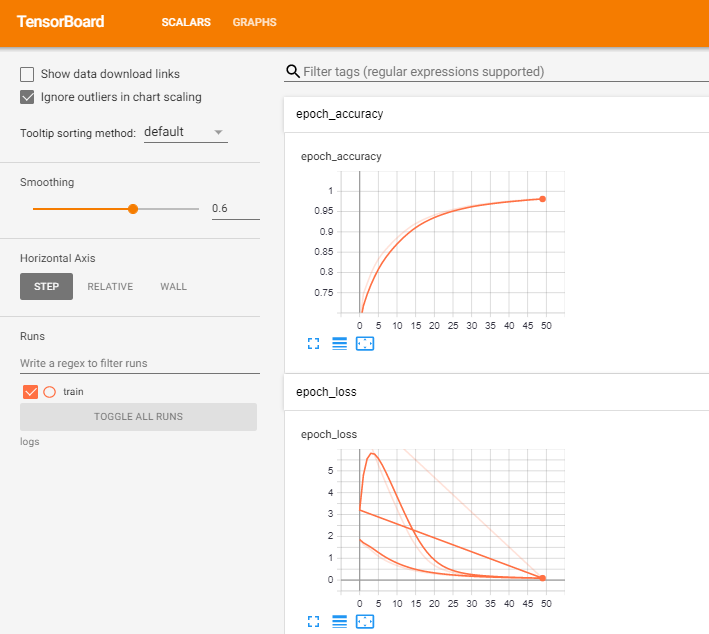

In [32]:
from IPython.display import Image
Image(filename='F:\\Applied AI\\Assignments\\25.NLP Attention Mechanism\\Tensorboard Results\\Task_1.PNG')

In [33]:
def get_encoder_data(input_sentence, tknizer_ita):
    
    input_seq = tknizer_ita.texts_to_sequences([input_sentence])
    print('Tokenized sentence:', input_seq[0])
    
    input_seq = np.array(input_seq)

    initial_state = model.layers[0].initialize_states(batch_size)
    state_h = initial_state[0]
    state_c = initial_state[1]

    enc_output, enc_state_h, enc_state_c = model.layers[0](input_seq)
    states_values = [enc_state_h, enc_state_c]
    
    return enc_output, enc_state_h, enc_state_c

In [40]:
# Refrence: https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb
def predict(input_sentence, tknizer_ita, print_=False):
    encoder_output, state_h, state_c = get_encoder_data(input_sentence, tknizer_ita)
    
    stop_condition=False
    k=0
    translated_sentence = ''
    
    target_word = np.zeros((1,1), dtype='float32')
    target_word[0,0] = 1
    
    while not stop_condition:
        target_word_emb = model.layers[1].embedding(target_word)
        output, state_h, state_c = model.layers[1](target_word, [state_h, state_c])
        output = model.layers[2](output)
        target_word = np.reshape(np.argmax(output), (1, 1))
        if(print_):
            print('Predicted Index ->', np.argmax(output))
            print(target_word[0][0])
        predicted_word = eng_index_word.get(int(target_word[0][0]), '')
        k+=1
        if ((k > len(input_sentence.split())) or target_word[0][0] == end_word_index):
            stop_condition = True
        translated_sentence = translated_sentence + ' ' + predicted_word
    return translated_sentence

In [41]:
input_sentence = "Come stai"
print('Given Sentence:', input_sentence)

output_sentence = predict(input_sentence, tknizer_ita, True)

print('Translated Sentence:', output_sentence)

Given Sentence: Come stai
Tokenized sentence: [47, 183]
Predicted Index -> 49
49
Predicted Index -> 11
11
Predicted Index -> 3
3
Translated Sentence:  how are you


In [36]:
# Blue Measurement
reference = [i.replace('<start> ', '').split() for i in list(validation['english_inp'])]
reference = reference[:1000]
print(len(reference))

1000


In [43]:
blue_score = 0
length = 10
for i in np.random.choice(list(validation.index), length):
    input_sentence = validation.loc[i, 'italian']
    print('Given Sentence:', input_sentence)
    translation = predict(input_sentence, tknizer_ita, False)
    print('Translated Sentence:', translation)
    reference = validation.loc[i, 'english_inp'].replace('<start> ', '').split()
    print('Reference:', reference)
    score = bleu.sentence_bleu([reference], translation.split())
    print('BLEU score: {}'.format(score))
    blue_score = blue_score + score
    print('\n')
print('Average Blue score: ', (blue_score/length))

Given Sentence: è divertente guardare la televisione
Tokenized sentence: [3, 354, 558, 8, 1014]
Translated Sentence:  it is that coming <end>
Reference: ['it', 'is', 'fun', 'to', 'watch', 'tv']
BLEU score: 6.867731683891005e-155


Given Sentence: qual è la sua lingua più forte
Tokenized sentence: [177, 3, 8, 60, 770, 33, 435]
Translated Sentence:  what is of <end>
Reference: ['what', 'is', 'your', 'strongest', 'language']
BLEU score: 7.422680762211792e-155


Given Sentence: tom si è comportato come un perfetto gentiluomo
Tokenized sentence: [1, 27, 3, 6544, 47, 11, 815, 4736]
Translated Sentence:  tom painting that that <end>
Reference: ['tom', 'acted', 'like', 'a', 'perfect', 'gentleman']
BLEU score: 9.97486269044271e-232


Given Sentence: tom è ancora il suo ragazzo vero
Tokenized sentence: [1, 3, 51, 9, 44, 392, 42]
Translated Sentence:  tom is is her <end>
Reference: ['tom', 'is', 'still', 'your', 'boyfriend', 'is', 'not', 'he']
BLEU score: 5.094696780347207e-155


Given Sentence: 